
## 0) Постановка задачи

Предсказать отказ компонента пневмосистемы (APS) по телеметрии датчиков грузовиков. Это бинарная классификация: pos — целевой отказ APS; neg — другие поломки. В официальной постановке есть стоимость ошибок: FP=10, FN=500 — пропуск "плохого" грузовика сильно дороже ложной тревоги.


In [ ]:
import io
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import sklearn                  # Алгоритмы машинного обучения
from google.colab import files

## 1) Чтение данных
Загружаем файл из локальной директории на компьютере:

In [ ]:
print("Загрузите два файла: aps_failure_training_set.csv и aps_failure_test_set.csv")
uploaded = files.upload()

train_key = next(k for k in uploaded if "training" in k.lower())
test_key  = next(k for k in uploaded if "test"  in k.lower())


Загрузите два файла: aps_failure_training_set.csv и aps_failure_test_set.csv


Saving aps_failure_test_set.csv to aps_failure_test_set (2).csv
Saving aps_failure_training_set.csv to aps_failure_training_set (3).csv


## 2) Разбиение на обучающую/тестовую

Поскольку в датасете файлы уже разделены на обучающую  ("training") и тестовую ("test"), опустим разбиение.


Таблицы содержат данные о техническом состоянии грузовиков компании Scania.
Каждая строка соответствует отдельному грузовику, прошедшему диагностику.
Для каждого грузовика указаны значения более чем 170 числовых признаков, характеризующих работу различных датчиков пневматической системы (Air Pressure System, APS) — давление, температура, расход, сопротивление и другие производные параметры.

In [ ]:
df_train = pd.read_csv(io.BytesIO(uploaded[train_key]), na_values=["na"])
df_test  = pd.read_csv(io.BytesIO(uploaded[test_key]),  na_values=["na"])

df_train.shape
df_test.shape

print("Обучающая выборка (train):")
display(df_train.head(5))
display(df_train.tail(5))

print("Тестовая выборка (test):")
display(df_test.head(5))
display(df_test.tail(5))

Обучающая выборка (train):


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
59995,neg,153002,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,neg,2286,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,neg,112,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,neg,80292,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0
59999,neg,40222,NaN,6.980000e+02,628.0,0.0,0.0,0.0,0.0,0.0,...,440066.0,183200.0,344546.0,254068.0,225148.0,158304.0,170384.0,158.0,0.0,0.0


Тестовая выборка (test):


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
15995,neg,81852,NaN,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,neg,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,neg,79636,NaN,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,neg,110,NaN,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0
15999,neg,8,0.0,6.000000e+00,4.0,2.0,2.0,0.0,0.0,0.0,...,46.0,10.0,48.0,14.0,42.0,46.0,0.0,0.0,0.0,0.0


- столбцы aa_000, ab_000, ac_000, … — **идентификаторы сенсоров или агрегированных параметров** (у Scania они не раскрыты по смыслу, только внутренние коды);

- значениями этих столбцов являются **измерения, полученные во время диагностики грузовика;**

- целевая колонка — **class** (pos = отказ APS, neg = исправно) - номинальная (категориальный) целевая переменная.

Таким образом, обе таблицы можно использовать для задач бинарной классификации: обучающая — для построения модели, тестовая — для оценки её качества.

Вначале рассмотрим размеры таблиц (количество строк — число грузовиков, количество столбцов — число признаков плюс целевая метка).

In [ ]:
print(f"Размер обучающей выборки: {df_train.shape}")
print(f"Размер тестовой выборки: {df_test.shape}")
print("\n")

df_train.info()

Размер обучающей выборки: (60000, 171)
Размер тестовой выборки: (16000, 171)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 78.3+ MB


Видим, что признаки — **числовые.**

Требуется предсказать бинарный признак class (pos / neg), указывающий наличие отказа APS, по остальным 170 числовым признакам телеметрии.

Столбец "class" содержит категориальные значения. Пока они имеют тип "object". Заменим тип на числовой:

In [ ]:
df_train['class'] = pd.Categorical(df_train['class'], categories=['neg','pos'])
df_test['class']  = pd.Categorical(df_test['class'],  categories=['neg','pos'])

Информация о числовых признаках:

In [ ]:
df_train.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,0.000000,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,0.000000,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


Информация о категориальных признаках:

In [ ]:
df_train.describe(include=['category'])

,class
count,60000
unique,2
top,neg
freq,59000


## Пропущенные значения:

In [ ]:
df_train.isnull().sum()

,0
class,0
aa_000,0
ab_000,46329
ac_000,3335
ad_000,14861
...,...
ee_007,671
ee_008,671
ee_009,671
ef_000,2724


## 3) Визуализация и вычисление основных характеристик

- работаем только с train, чтобы не "подглядывать" в test;
- смотрим размеры, долю класса pos:

In [ ]:
y = df_train['class'].map({'neg': 0, 'pos': 1}).astype('int8')
X = df_train.drop(columns=['class'])

N, d = X.shape
pos_rate = float(y.mean()) * 100
print(f"[INFO] TRAIN: N={N}, d={d}, pos_rate={pos_rate:.2f}%")

[INFO] TRAIN: N=60000, d=170, pos_rate=1.67%


**Распределение классов**. В TRAIN доля положительного класса составляет ≈ 1.67% — наблюдается сильный дисбаланс (мало pos). Это повлияет на выбор метрик и моделей.

Считаем средние, разброс, дисперсии, и долю пропусков

In [ ]:
desc = X.describe().T
var = X.var(ddof=1)                  # дисперсия
missing_pct = X.isna().mean() * 100  # доля пропусков по столбцам, %

stats = desc[['count','mean','std','min','25%','50%','75%','max']].copy()
stats['variance'] = var
stats['missing_%'] = missing_pct

print("Первые 10 строк сводной таблицы по признакам:")
display(stats.head(10))

overall_missing_pct = float(X.isna().values.mean() * 100)
print(f"Общая доля пропусков в X (TRAIN): {overall_missing_pct:.2f}%")

print("Топ-10 признаков по доле пропусков:")
display(missing_pct.sort_values(ascending=False).head(10).to_frame("missing_%"))

Первые 10 строк сводной таблицы по признакам:


,count,mean,std,min,25%,50%,75%,max,variance,missing_%
aa_000,60000.0,5.933650e+04,1.454301e+05,0.0,834.0,30776.0,48668.0,2.746564e+06,2.114990e+10,0.000000
ab_000,13671.0,7.131885e-01,3.478962e+00,0.0,0.0,0.0,0.0,2.040000e+02,1.210318e+01,77.215000
ac_000,56665.0,3.560143e+08,7.948749e+08,0.0,16.0,152.0,964.0,2.130707e+09,6.318261e+17,5.558333
ad_000,45139.0,1.906206e+05,4.040441e+07,0.0,24.0,126.0,430.0,8.584298e+09,1.632516e+15,24.768333
ae_000,57500.0,6.819130e+00,1.615434e+02,0.0,0.0,0.0,0.0,2.105000e+04,2.609626e+04,4.166667
af_000,57500.0,1.100682e+01,2.097926e+02,0.0,0.0,0.0,0.0,2.007000e+04,4.401293e+04,4.166667
ag_000,59329.0,2.216364e+02,2.047846e+04,0.0,0.0,0.0,0.0,3.376892e+06,4.193675e+08,1.118333
ag_001,59329.0,9.757223e+02,3.420053e+04,0.0,0.0,0.0,0.0,4.109372e+06,1.169676e+09,1.118333
ag_002,59329.0,8.606015e+03,1.503220e+05,0.0,0.0,0.0,0.0,1.055286e+07,2.259671e+10,1.118333
ag_003,59329.0,8.859128e+04,7.617312e+05,0.0,0.0,0.0,0.0,6.340207e+07,5.802344e+11,1.118333


Общая доля пропусков в X (TRAIN): 8.33%
Топ-10 признаков по доле пропусков:


,missing_%
br_000,82.106667
bq_000,81.203333
bp_000,79.566667
bo_000,77.221667
ab_000,77.215000
cr_000,77.215000
bn_000,73.348333
bm_000,65.915000
bl_000,45.461667
bk_000,38.390000


**Средние и разброс.** Масштабы признаков заметно различаются (значения std/variance отличаются на порядки) — для методов, чувствительных к масштабу (KNN, логистическая регрессия), нужна нормализация (будет далее).

**Пропуски.** Общая доля пропусков в матрице признаков ≈ 8.33%; у некоторых колонок она высокая ("Топ-10"). Далее будем удалять (часто — медианой).

Строим корреляционную матрицу признаков:

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.073103,-0.032055,-0.001903,0.061971,0.089474,0.018610,0.143153,0.285815,0.495529,...,0.735324,0.739211,0.717810,0.727240,0.726984,0.606232,0.471707,0.248039,0.019865,0.037099
ab_000,0.073103,1.000000,-0.019411,0.047281,0.031031,0.053532,0.008418,0.013658,0.050068,0.068100,...,0.062280,0.098808,0.068790,0.078091,0.048717,0.023867,0.039369,0.074119,0.055590,0.162948
ac_000,-0.032055,-0.019411,1.000000,-0.002380,-0.004997,-0.010554,0.017620,-0.001088,-0.016665,-0.038680,...,-0.013692,-0.008111,-0.009849,-0.011206,-0.021430,-0.029417,0.016908,0.024354,-0.006571,0.014228
ad_000,-0.001903,0.047281,-0.002380,1.000000,-0.000214,-0.000269,-0.000047,-0.000131,-0.000222,-0.000423,...,-0.002090,-0.002047,-0.001940,-0.001667,-0.001398,-0.000829,-0.002161,-0.001050,-0.000102,-0.000120
ae_000,0.061971,0.031031,-0.004997,-0.000214,1.000000,0.823108,-0.000430,-0.000832,0.005057,0.034163,...,0.017338,0.024905,0.017311,0.039967,0.085884,0.052357,-0.010850,-0.008206,0.070886,0.041715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.606232,0.023867,-0.029417,-0.000829,0.052357,0.070306,0.000307,0.044186,0.182990,0.505565,...,0.454833,0.446803,0.437682,0.379892,0.545929,1.000000,0.224938,0.061478,-0.000715,0.002708
ee_008,0.471707,0.039369,0.016908,-0.002161,-0.010850,-0.013976,-0.000823,0.004878,0.009466,0.021151,...,0.453811,0.481392,0.459517,0.406920,0.373871,0.224938,1.000000,0.710056,-0.006991,-0.002833
ee_009,0.248039,0.074119,0.024354,-0.001050,-0.008206,-0.010237,-0.001230,-0.004309,-0.009498,-0.019311,...,0.228248,0.239302,0.224638,0.190667,0.163792,0.061478,0.710056,1.000000,-0.003942,-0.000907
ef_000,0.019865,0.055590,-0.006571,-0.000102,0.070886,0.106281,-0.000072,0.002875,0.011824,0.020560,...,0.007118,0.017480,0.005835,0.050270,0.008461,-0.000715,-0.006991,-0.003942,1.000000,0.282184


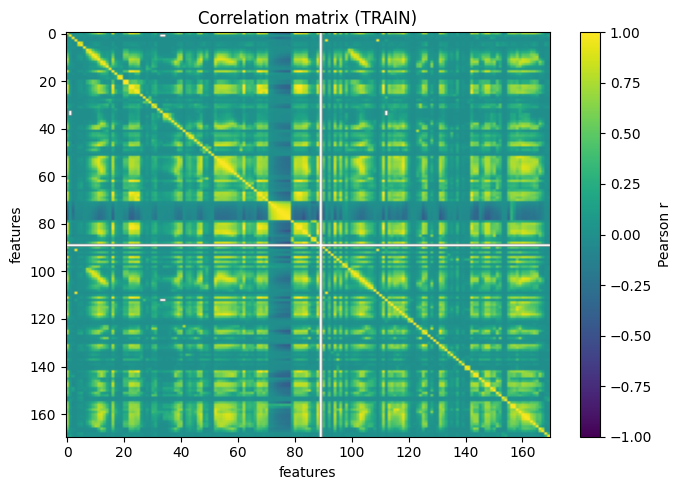

In [ ]:
corr = X.corr(method='pearson', min_periods=1)

display(corr)

# Небольшая тепловая карта (чтобы "увидеть" блоки корреляций)
plt.figure(figsize=(7,5))
plt.imshow(corr.values, vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Pearson r')
plt.title('Correlation matrix (TRAIN)')
plt.xlabel('features'); plt.ylabel('features')
plt.tight_layout(); plt.show()

**Корреляции между признаками**. На тепловой карте видны "блоки" зависимостей — есть мультиколлинеарность. Это нормально, но при желании можно делать отбор/регуляризацию.

Находим связь каждого признака с целевой

In [78]:
MIN_NONNA = 50
good = [c for c in X.columns if (X[c].count() >= MIN_NONNA) and (X[c].var(ddof=1) > 0)]

target_corr = X[good].corrwith(y, method='pearson').dropna()
top10 = target_corr.abs().sort_values(ascending=False).head(10)

print("Top-10 признаков по |corr с целевой|:")
display(pd.DataFrame({'feature': top10.index, 'abs_corr_with_y': top10.values}))

Top-10 признаков по |corr с целевой|:


,feature,abs_corr_with_y
0,ci_000,0.553308
1,bb_000,0.542744
2,bv_000,0.541598
3,bu_000,0.541598
4,cq_000,0.541598
5,bt_000,0.537452
6,aa_000,0.536978
7,aq_000,0.531135
8,bj_000,0.525249
9,ah_000,0.524591


**Связь с целевой.** Несколько признаков показывают повышенную корреляцию с class; на гистограммах у pos и neg различаются, что подтверждает их информативность.

Рисуем 2 гистограммы по "самым связанным" признакам:

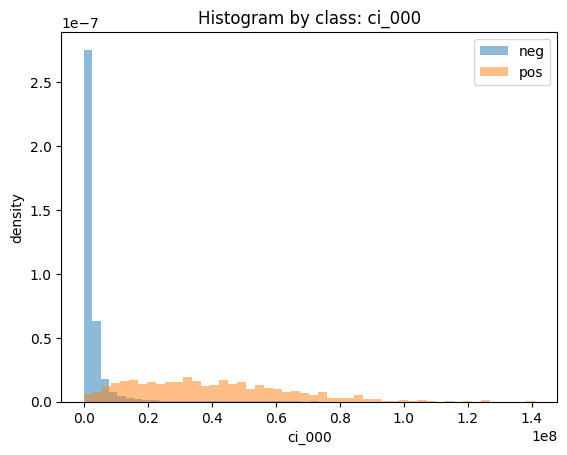

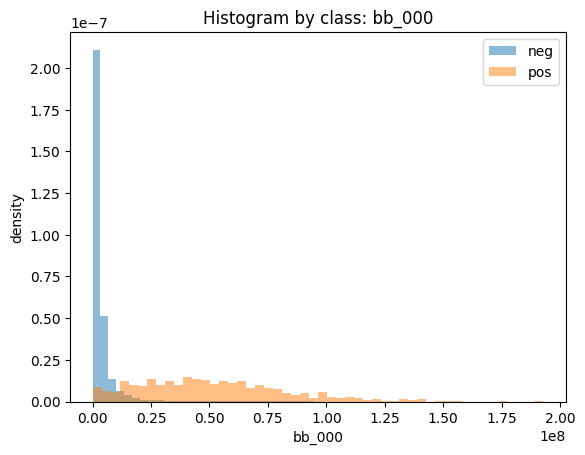

In [ ]:
top_cols = target_corr.abs().sort_values(ascending=False).index[:2]

for col in top_cols:
    plt.figure()
    X[y==0][col].dropna().plot(kind='hist', bins=50, alpha=0.5, density=True, label='neg')
    X[y==1][col].dropna().plot(kind='hist', bins=50, alpha=0.5, density=True, label='pos')
    plt.title(f"Histogram by class: {col}")
    plt.xlabel(col); plt.ylabel("density"); plt.legend()
    plt.show()

## 4) Предобработка: пропуски → медиана, категориальных признаков в X нет, class — целевая метка, нормализация количественных признаков

In [ ]:
y_train = df_train['class'].map({'neg':0,'pos':1}).astype('int8')
y_test  = df_test['class'].map({'neg':0,'pos':1}).astype('int8')
X_train = df_train.drop(columns=['class']).copy()
X_test  = df_test.drop(columns=['class']).copy()

medians = X_train.median(numeric_only=True)
X_train = X_train.fillna(medians)
X_test  = X_test.fillna(medians)

print("NaN% train:", X_train.isna().to_numpy().mean()*100,
      "NaN% test:",  X_test.isna().to_numpy().mean()*100)

NaN% train: 0.0 NaN% test: 0.0


Вывод: импутация прошла корректно: NaN нет ни в train, ни в test, и утечки нет.

Нормализация:


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

# Быстрая проверка:
print("mean[:5] =", np.mean(X_train_scaled.values, axis=0)[:5].round(3))
print("std[:5]  =", np.std(X_train_scaled.values, axis=0, ddof=0)[:5].round(3))

mean[:5] = [ 0.  0.  0. -0.  0.]
std[:5]  = [1. 1. 1. 1. 1.]


In [ ]:
X_train_scaled.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,...,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04
mean,4.736952e-19,1.918465e-17,2.463215e-17,-4.440892e-19,5.181041e-18,-1.835569e-17,-3.552714e-19,-1.030287e-17,6.809368e-18,-2.472097e-17,...,2.155313e-17,1.302662e-17,1.634248e-17,1.184238e-19,-4.204045e-18,4.973799e-18,-2.178998e-17,6.335673e-18,-1.332268e-18,-1.421085e-18
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,...,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-4.080105e-01,-9.630750e-02,-4.328589e-01,-4.092980e-03,-4.132243e-02,-5.135808e-02,-1.076230e-02,-2.836958e-02,-5.692893e-02,-1.156426e-01,...,-3.855698e-01,-3.886589e-01,-3.814370e-01,-3.512834e-01,-3.106542e-01,-1.994928e-01,-3.068377e-01,-1.756986e-01,-2.025676e-02,-2.353972e-02
25%,-4.022758e-01,-9.630750e-02,-4.328589e-01,-4.091781e-03,-4.132243e-02,-5.135808e-02,-1.076230e-02,-2.836958e-02,-5.692893e-02,-1.156426e-01,...,-3.829302e-01,-3.864308e-01,-3.789856e-01,-3.478402e-01,-3.101276e-01,-1.994242e-01,-3.068377e-01,-1.756986e-01,-2.025676e-02,-2.353972e-02
50%,-1.963881e-01,-9.630750e-02,-4.328587e-01,-4.089384e-03,-4.132243e-02,-5.135808e-02,-1.076230e-02,-2.836958e-02,-5.692893e-02,-1.156426e-01,...,-1.821391e-01,-1.812336e-01,-1.908006e-01,-1.808837e-01,-2.237376e-01,-1.755799e-01,-2.983138e-01,-1.756986e-01,-2.025676e-02,-2.353972e-02
75%,-7.335890e-02,-9.630750e-02,-4.328579e-01,-4.084648e-03,-4.132243e-02,-5.135808e-02,-1.076230e-02,-2.836958e-02,-5.692893e-02,-1.156426e-01,...,-7.039959e-03,1.189033e-02,1.655663e-02,7.745365e-03,-5.439360e-02,-1.027038e-01,-1.108315e-03,-1.347345e-01,-2.025676e-02,-2.353972e-02
max,1.847795e+01,1.208066e+02,2.310225e+00,2.449469e+02,1.330630e+02,9.766737e+01,1.658201e+02,1.208049e+02,7.053990e+01,8.358227e+01,...,6.742633e+01,6.948666e+01,8.322702e+01,5.116221e+01,2.941112e+01,6.937838e+01,4.277664e+01,8.052562e+01,1.128990e+02,1.328003e+02


In [ ]:
X_test_scaled.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,...,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,0.059551,0.007705,0.001406,-0.004083,-0.002427,-0.003856,-0.004897,0.031610,0.034250,0.031282,...,0.016548,0.018270,0.019700,0.027962,0.021058,0.003379,0.012006,0.003443,-0.005761,0.003248
std,3.462415,0.756265,1.001349,0.000039,0.731076,0.796683,0.315095,2.609023,1.568418,1.346302,...,1.085820,1.072386,1.084525,1.123132,1.121503,0.942075,1.193645,1.122316,0.771539,1.621878
min,-0.408011,-0.096307,-0.432859,-0.004093,-0.041322,-0.051358,-0.010762,-0.028370,-0.056929,-0.115643,...,-0.385570,-0.388659,-0.381437,-0.351283,-0.310654,-0.199493,-0.306838,-0.175699,-0.020257,-0.023540
25%,-0.401629,-0.096307,-0.432859,-0.004092,-0.041322,-0.051358,-0.010762,-0.028370,-0.056929,-0.115643,...,-0.382704,-0.386253,-0.378767,-0.347529,-0.310022,-0.199413,-0.306838,-0.175699,-0.020257,-0.023540
50%,-0.194972,-0.096307,-0.432859,-0.004089,-0.041322,-0.051358,-0.010762,-0.028370,-0.056929,-0.115643,...,-0.180690,-0.181234,-0.190346,-0.180884,-0.223738,-0.175580,-0.298314,-0.175699,-0.020257,-0.023540
75%,-0.067782,-0.096307,-0.432858,-0.004084,-0.041322,-0.051358,-0.010762,-0.028370,-0.056929,-0.115643,...,-0.006334,0.013106,0.021080,0.008159,-0.050697,-0.101833,-0.002951,-0.137827,-0.020257,-0.023540
max,294.923168,34.278062,2.310224,-0.001609,69.792628,69.018789,36.140926,307.908894,128.047726,96.328493,...,46.447211,40.471815,41.441135,49.913946,39.333127,27.421802,38.121916,96.629967,79.632366,199.328081


## 5) Запуск классификатор

Почему логистическая регрессия? Бинарная классификация с дисбалансом классов. Логистическая регрессия даёт вероятности (удобно затем подбирать порог под стоимость ошибок), быстро обучается и устойчива. Используем class_weight="balanced".

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

lr = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")
lr.fit(X_train_scaled, y_train)

y_proba_tr = lr.predict_proba(X_train_scaled)[:, 1]
y_pred_tr  = (y_proba_tr >= 0.5).astype(int)

y_proba_te = lr.predict_proba(X_test_scaled)[:, 1]
y_pred_te  = (y_proba_te >= 0.5).astype(int)

def show_metrics(name, y_true, y_pred, y_proba):
    print(name, {
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "BalancedAcc": round(balanced_accuracy_score(y_true, y_pred), 4),
        "ROC_AUC": round(roc_auc_score(y_true, y_proba), 4)
    })

show_metrics("TRAIN", y_train, y_pred_tr, y_proba_tr)
show_metrics("TEST ", y_test,  y_pred_te, y_proba_te)

cm_tr = confusion_matrix(y_train, y_pred_tr, labels=[0,1])
cm_te = confusion_matrix(y_test,  y_pred_te,  labels=[0,1])
print("\nConfusion — TRAIN (labels=[0,1]):\n", cm_tr)
print("\nConfusion — TEST  (labels=[0,1]):\n", cm_te)

TRAIN {'Accuracy': 0.9754, 'BalancedAcc': np.float64(0.9673), 'ROC_AUC': np.float64(0.9917)}
TEST  {'Accuracy': 0.975, 'BalancedAcc': np.float64(0.9495), 'ROC_AUC': np.float64(0.9793)}

Confusion — TRAIN (labels=[0,1]):
 [[57564  1436]
 [   41   959]]

Confusion — TEST  (labels=[0,1]):
 [[15254   371]
 [   29   346]]


- TP (true positive) — предсказали "отказ есть", и он действительно есть.

- FP (false positive) — предсказали "отказ есть", а его нет (ложная тревога).

- FN (false negative) — предсказали "отказа нет", а он есть (пропуск отказа).

- TN (true negative) — предсказали "отказа нет", и его нет

В матрице ошибок важны FN (пропуск отказа) и FP (ложная тревога). Для APS обычно критичнее уменьшать FN.

Модель логистической регрессии на стандартной подготовке (медианная импутация + нормализация) показывает высокое качество ранжирования (ROC-AUC ≈ 0.98) и сбалансированную точность (≈0.95) на тесте.

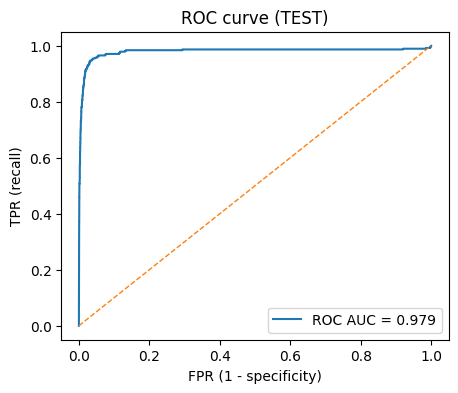

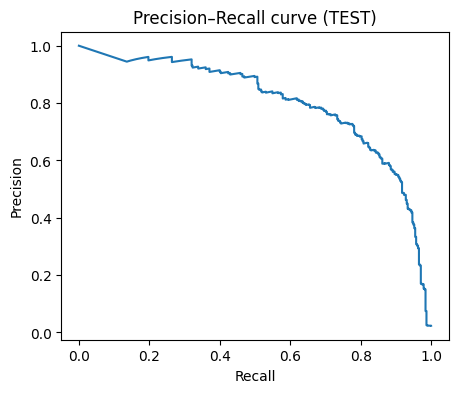

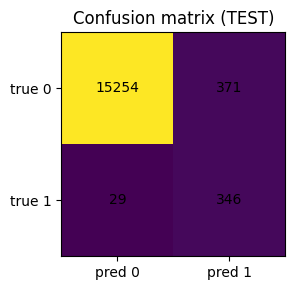

In [76]:
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC
fpr, tpr, thr = roc_curve(y_test, y_proba_te)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba_te):.3f}")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("FPR (1 - specificity)"); plt.ylabel("TPR (recall)")
plt.title("ROC curve (TEST)"); plt.legend(); plt.show()

# PR
prec, rec, thr_pr = precision_recall_curve(y_test, y_proba_te)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curve (TEST)"); plt.show()

plt.figure(figsize=(4,3))
plt.imshow(cm_te, aspect='equal')
plt.xticks([0,1], ["pred 0","pred 1"]); plt.yticks([0,1], ["true 0","true 1"])
for (i,j),v in np.ndenumerate(cm_te):
    plt.text(j, i, int(v), ha='center', va='center')
plt.title("Confusion matrix (TEST)"); plt.tight_layout(); plt.show()

In [77]:
from sklearn.metrics import confusion_matrix

FP_COST = 10
FN_COST = 500

ths = np.linspace(0.0, 1.0, 101)
best = None

for t in ths:
    y_pred_t = (y_proba_te >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t, labels=[0,1]).ravel()
    cost = FP_COST*fp + FN_COST*fn
    if (best is None) or (cost < best[0]):
        best = (cost, t, (tn, fp, fn, tp))

best_cost, best_thr, (tn, fp, fn, tp) = best
print(f"Лучший порог по стоимости: thr={best_thr:.2f}, cost={best_cost}")
print(f"Confusion @thr={best_thr:.2f}: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

Лучший порог по стоимости: thr=0.27, cost=14960
Confusion @thr=0.27: TN=15029, FP=596, FN=18, TP=357


## 6) Вывод
Мы обучили на обучающей выборке модель логистической регрессии, которая по 170 числовым признакам телеметрии предсказывает вероятность отказа APS. На тестовой выборке модель показала высокое качество: BA ≈ 0.95, ROC-AUC ≈ 0.98, матрица ошибок: TN=15254, FP=371, FN=29, TP=346.

В ходе обучения решалась задача бинарной классификации отказа APS по 170 числовым признакам.
В EDA увидели разные масштабы признаков и заметные корреляции, пропуски заполнили медианой (считалась по train), затем нормализовали признаки, Поскольку данные сильно несбалансированы (мало pos), брали LogisticRegression.Данный метод дал на тесте высокие Balanced Accuracy и ROC-AUC, матрица ошибок показывает разумный компромисс между FN и FP. С учётом асимметричной стоимости ошибок (FN дороже FP) смещение порога позволяет дополнительно сократить FN. Модель нашла ~92% реальных отказов, отметив 717 машин "в риск", из которых ~48% действительно с проблемой.